In [1]:

import sys
import os
sys.path.append("..")

import jax.numpy as jnp
import jax
import numpy as np
import matplotlib.pyplot as plt
from jax import grad, jit, vmap
import numpyro
from numpyro import distributions as dist
from numpyro import infer

from numpyro_ext import distributions as distx
from numpyro_ext import info, optim

numpyro.set_host_device_count(
    1
)  # For multi-core parallelism (useful when running multiple MCMC chains in parallel)
numpyro.set_platform("cpu")  # For CPU (use "gpu" for GPU)
jax.config.update(
    "jax_enable_x64", True
)
#jax.config.update('jax_disable_jit', True)

from jaxoplanet import light_curves, orbits
from jaxoplanet.light_curves import limb_dark_light_curve
import arviz as az
import corner

from eclipsoid.light_curve import legacy_oblate_lightcurve, compute_bounds
import os
import pandas as pd
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=2"

oblate_lightcurve = jit(legacy_oblate_lightcurve)


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def q_to_u(q1, q2): 
    u1 = 2.*jnp.sqrt(jnp.abs(q1))*q2
    u2 = jnp.sqrt(jnp.abs(q1))*(1-(2*q2))
    return u1,u2

In [3]:
q1 = 0.04
q2 = 0.24
u1,u2 = q_to_u(q1, q2)
init_params = {'r_circ':jnp.sqrt((0.1446)**2),
               'u':jnp.array([u1, u2]),
                'bo':0.11650,
                'log_d': jnp.log(2.753/24),
                'hk':jnp.array([jnp.sqrt(0.0001)*jnp.sin(jnp.radians(20)), jnp.sqrt(0.0001)*jnp.cos(jnp.radians(20))])
               
}
init_params['f'] = 0.1
init_params['theta'] = np.radians(20)
init_params['duration']=np.exp(init_params['log_d'])
init_params['radius'] = np.sqrt(init_params['r_circ']**2/(1-init_params['f']))
init_params['period'] = 5.7214742



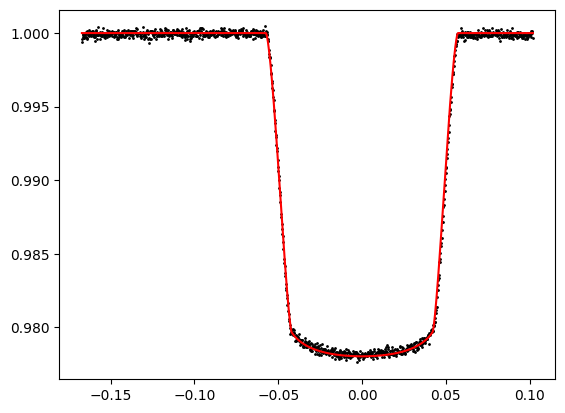

In [4]:

df = pd.read_csv('Sing_2024_Fig1_WASP107b_white_light_curve_data.csv')
t = jnp.array(df['bjd_tdb(days)']-2460118.948861)
#f = df['NRS1_wlc_flux']
f = jnp.array(df['NRS2_wlc_flux'])
yerr = jnp.array(df['NRS2_wlc_flux_err'])
plt.scatter(t,f,c='k',s=1)
plt.plot(t,oblate_lightcurve(init_params, t),c='r')

In [5]:
def model(t, yerr, y=None):
    # If we wanted to fit for all the parameters, we could use the following,
    # but we'll keep these fixed for simplicity.
    
    #log_duration = numpyro.sample("log_duration", dist.Uniform(jnp.log(0.08), jnp.log(0.2)))
    #b = numpyro.sample("b", dist.Uniform(0.0, 1.0))

    #log_jitter = numpyro.sample("log_jitter", dist.Normal(jnp.log(yerr), 1.0))
    r_circ = numpyro.sample("r_circ", dist.Uniform(0.01, 0.2))
    u = numpyro.sample("u", distx.QuadLDParams())
    bo = numpyro.sample("bo", dist.Uniform(0.0,1.))
    
    #parametrize f, theta using a unit disk
    hk = numpyro.sample("hk", distx.UnitDisk())
    f = numpyro.deterministic("f", (hk[0] ** 2 + hk[1] ** 2)/2)
    theta = numpyro.deterministic("theta", jnp.arctan2(hk[1], hk[0])/2)
    
    # The duration
    log_d = numpyro.sample("log_d", numpyro.distributions.Normal(jnp.log(init_params['duration']), 0.01))
    duration = numpyro.deterministic("duration", jnp.exp(log_d))
    t0 = numpyro.sample("t0", dist.Uniform(-0.0001, 0.0001))
    params = {
        'period':init_params['period'],
        't0': t0,
        "radius": jnp.sqrt(r_circ**2/(1-f)),
        'bo':bo,
        'u': u,
        'f':f, 
        'theta':theta,
        'duration': duration
    }
    y_pred = oblate_lightcurve(params, t)
    numpyro.deterministic("light_curve", y_pred)
    numpyro.sample(
        "flux",
        dist.Normal(y_pred, jnp.sqrt(yerr**2) #+ jnp.exp(2 * log_jitter))
                    ),
        obs=y,
    )

In [6]:
import numpyro_ext.distributions, numpyro_ext.optim


run_optim = numpyro_ext.optim.optimize(
        model,
        init_strategy=numpyro.infer.init_to_value(values=init_params),
        return_info=True
    )

opt_params, status = run_optim(jax.random.PRNGKey(2), t, yerr, y=f)

In [7]:
opt_params

{'r_circ': Array(0.14411448, dtype=float64),
 'u': Array([0.07794656, 0.14130711], dtype=float64),
 'bo': Array(0.09529572, dtype=float64),
 'hk': Array([ 0.05001321, -0.34298855], dtype=float64),
 'log_d': Array(-2.16229489, dtype=float64),
 't0': Array(-3.34442792e-05, dtype=float64),
 'duration': Array(0.11506077, dtype=float64),
 'f': Array(0.06007123, dtype=float64),
 'flux': Array([0.99957961, 0.99941671, 0.99995651, ..., 1.00006389, 1.00013725,
        0.99963939], dtype=float64),
 'light_curve': Array([1., 1., 1., ..., 1., 1., 1.], dtype=float64),
 'theta': Array(-0.71300042, dtype=float64)}

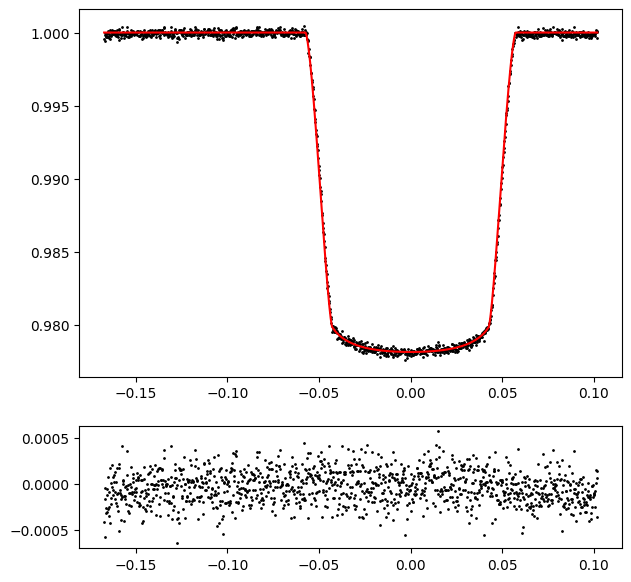

In [8]:
opt_params['radius'] = np.sqrt(opt_params['r_circ']**2/(1-opt_params['f']))
opt_params['period'] = 5.7214742
fig, (ax, ax1) = plt.subplots(2,1,figsize=(7,7), gridspec_kw={'height_ratios': [3, 1]})
ax.scatter(t,f,c='k',s=1)
ax.plot(t,oblate_lightcurve(opt_params, t),c='r')
ax1 = plt.scatter(t, f-oblate_lightcurve(opt_params, t), c='k', s=1)

In [9]:
sampler_wn = infer.MCMC(
    infer.NUTS(
        model,
        target_accept_prob=0.8,
        dense_mass=True,
        init_strategy=infer.init_to_value(values=opt_params),
        regularize_mass_matrix=False,
        max_tree_depth=5
    ),
    num_warmup=1000,
    num_samples=2000,
    num_chains=2,
    progress_bar=True,
)
%time sampler_wn.run(jax.random.PRNGKey(11), t, yerr, f)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]